### ***Notebook III: Training CNN***
 
****

## **1. Libraries**

In [ ]:
import sys
import os
import IPython
import math
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

import random
from datetime import datetime
from keras.models import Sequential, load_model
from keras.layers import Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical #from keras.utils import to_categorical
from keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## **2. Urban Sound Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#load paths
drive.mount('/content/drive')

main_project_path='/content/drive/MyDrive/UrbanSound8K'
audio_path = main_project_path+'/audio'
metadata_path = main_project_path+'/metadata/UrbanSound8K.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
metadata = pd.read_csv(metadata_path) 
metadata.head(10)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
5,100263-2-0-143.wav,100263,71.500000,75.500000,1,5,2,children_playing
6,100263-2-0-161.wav,100263,80.500000,84.500000,1,5,2,children_playing
7,100263-2-0-3.wav,100263,1.500000,5.500000,1,5,2,children_playing
8,100263-2-0-36.wav,100263,18.000000,22.000000,1,5,2,children_playing
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn


In [ ]:
def split_data(x,y,train=[],test=[],metadata=metadata):
  x_train,y_train=[],[]
  training_indexes,test_indexes=[],[]
  for ind in train:
    training_indexes=training_indexes+[idx_ for idx_ in metadata.loc[(metadata['fold'] == ind)].index.values]
  x_train=[ x[i] for i in sorted(training_indexes)]
  y_train=[ y[i] for i in sorted(training_indexes)]
  for ind in test:
    test_indexes=test_indexes+[idx_ for idx_ in metadata.loc[(metadata['fold'] == ind)].index.values]
  x_test=[ x[i] for i in sorted(test_indexes)]
  y_test=[ y[i] for i in sorted(test_indexes)]
  return np.array(x_train) , np.array( y_train ) ,np.array(  x_test ) , np.array( y_test) ,training_indexes,test_indexes

## **3. Methods for Performance Metrics Measures & Graph Plotting**

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    train_score = model.evaluate(X_train, y_train, verbose=0)
    test_score = model.evaluate(X_test, y_test, verbose=0)
    return train_score, test_score

In [ ]:
def model_evaluation_report(model, X_train, y_train, X_test, y_test, calc_normal=True):
    dash = '-' * 38
    train_score, test_score = evaluate_model(model, X_train, y_train, X_test, y_test)
    
    print('{:<10s}{:>14s}{:>14s}'.format("", "LOSS", "ACCURACY"))
    print(dash)
    print('{:<10s}{:>14.4f}{:>14.4f}'.format( "Training:", train_score[0], 100 * train_score[1]))
    print('{:<10s}{:>14.4f}{:>14.4f}'.format( "Test:", test_score[0], 100 * test_score[1]))
    if (calc_normal):
        max_err = max(train_score[0], test_score[0])
        error_diff = max_err - min(train_score[0], test_score[0])
        normal_diff = error_diff * 100 / max_err
        print('{:<10s}{:>13.2f}{:>1s}'.format("Normal diff ", normal_diff, ""))

In [ ]:
def acc_plot(m):
  plt.figure(figsize=(8,5))
  sb.set_style("whitegrid")
  plt.plot(m.history['accuracy'],color="#E74C3C",marker='o')
  plt.plot(m.history['val_accuracy'],color='#641E16',marker='h')
  plt.title('Accuracy comparison between Validation and Train Data set',fontsize=15)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='best')
  plt.show()

In [ ]:
def acc_per_class(np_probs_array):    
    accs = []
    for idx in range(0, np_probs_array.shape[0]):
        correct = np_probs_array[idx][idx].astype(int)
        total = np_probs_array[idx].sum().astype(int)
        acc = (correct / total) * 100
        accs.append(acc)
    return accs

## **4. Loading Extracted MFCCs**

In [ ]:
X = np.load(main_project_path+"/X-mfcc.npy")#load xmfcc and ymfcc path
y = np.load(main_project_path+"/y-mfcc.npy")

## **5 Train and Test Splitting**

In [ ]:
indexes = []
total = 8262 #Some files was corrupted...so I just ignored them.
indexes = list(range(0, total))
random.shuffle(indexes) #Randomizing Indexes

In [ ]:
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)

In [ ]:
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]

In [ ]:
#Spliting the features with the same indexes

X_train,y_train,X_test,y_test,train_split_idx,test_split_idx= split_data(X,y,train=[1,2,3,4,6],test=[5,7,8,9,10])

In [ ]:
#Also spliting metadata
test_meta = metadata.iloc[test_split_idx]
train_meta = metadata.iloc[train_split_idx]

In [ ]:
print("--------------------Test Data Details--------------------")
print("Test split: {} ".format(len(test_meta)))
print("X test shape: {} ".format(X_test.shape))
print("y test shape: {} ".format(y_test.shape))
print("--------------------Train Data Details--------------------")
print("Train split: {}".format(len(train_meta)))
print("X train shape: {}".format(X_train.shape))
print("y train shape: {}".format(y_train.shape))

--------------------Test Data Details--------------------
Test split: 4233 
X test shape: (4233, 40, 174) 
y test shape: (4233,) 
--------------------Train Data Details--------------------
Train split: 4499
X train shape: (4499, 40, 174)
y train shape: (4499,)


## **6. Normalizing the Data**

In [ ]:
num_rows = 40
num_columns = 174
num_channels = 1

In [ ]:
le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))

In [ ]:
# Reshape to fit the network input (channel last)
X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

In [ ]:
# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]

In [ ]:
X_train.shape

(4499, 40, 174, 1)

Text(0, 0.5, 'Variance (%)')

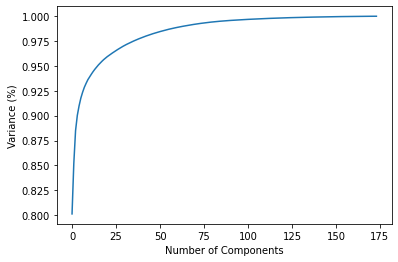

In [ ]:
# Check PCA benefits
scaler = StandardScaler()
scaler.fit(X_train[:,0, ::,0])
x_train_scaled = scaler.transform(X_train[:,0, ::,0])

pca = PCA().fit(x_train_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')

As we can see most of the variance is explained using all the features of the MFCC. This is expected since each feature gives information about the wave shape. Finally we can fit our model.

### 7. CNN Model Architecture - Model1 



In [ ]:
def create_model(spatial_dropout_rate_1=0, spatial_dropout_rate_2=0, l2_rate=0):

    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), kernel_regularizer=l2(l2_rate), input_shape=(num_rows, num_columns, num_channels)))
    model.add(LeakyReLU(alpha=0.1))

    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))

    
    model.add(Conv2D(filters=64, kernel_size=(3,3), kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dense(num_labels, activation='softmax'))
    return model

In [ ]:
#Regularization rates
spatial_dropout_rate_1 = 0.07
spatial_dropout_rate_2 = 0.14
l2_rate = 0.0005
#Calling Model
model = create_model(spatial_dropout_rate_1, spatial_dropout_rate_2, l2_rate)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 38, 172, 32)       320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 38, 172, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 170, 32)       9248      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 36, 170, 32)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 85, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 83, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 83, 64)        0

In [ ]:
adam = Adam(lr=1e-4, beta_1=0.99, beta_2=0.999)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
from keras.callbacks import EarlyStopping
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=25, verbose=1, mode='auto')

In [ ]:
history = model.fit(X_train, y_train_encoded, batch_size=128, epochs=250, validation_split=1/12., verbose=1, callbacks=[early])

Epoch 1/250
33/33 [==============================] - 48s 109ms/step - loss: 2.3684 - accuracy: 0.1216 - val_loss: 2.3568 - val_accuracy: 0.1387
Epoch 2/250
33/33 [==============================] - 2s 54ms/step - loss: 2.3497 - accuracy: 0.1082 - val_loss: 2.3365 - val_accuracy: 0.1893
Epoch 3/250
33/33 [==============================] - 2s 54ms/step - loss: 2.3207 - accuracy: 0.1297 - val_loss: 2.3248 - val_accuracy: 0.1147
Epoch 4/250
33/33 [==============================] - 2s 55ms/step - loss: 2.2903 - accuracy: 0.1061 - val_loss: 2.3339 - val_accuracy: 0.1147
Epoch 5/250
33/33 [==============================] - 2s 55ms/step - loss: 2.2713 - accuracy: 0.1138 - val_loss: 2.3139 - val_accuracy: 0.1147
Epoch 6/250
33/33 [==============================] - 2s 55ms/step - loss: 2.2483 - accuracy: 0.1083 - val_loss: 2.2790 - val_accuracy: 0.1280
Epoch 7/250
33/33 [==============================] - 2s 55ms/step - loss: 2.2173 - accuracy: 0.1143 - val_loss: 2.2511 - val_accuracy: 0.1120
Epoc

In [ ]:
labels = ['Air Conditioner', 'Car Horn', 'Children Playing', 'Dog bark', 'Drilling', 'Engine Idling', 'Gun Shot', 'Jackhammer', 'Siren', 'Street Music']

In [ ]:
model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

                    LOSS      ACCURACY
--------------------------------------
Training:         1.3919       55.6346
Test:             1.7894       42.7120
Normal diff         22.21 


### CNN - Model 2

In [ ]:
def create_model(spatial_dropout_rate_1=0, spatial_dropout_rate_2=0, l2_rate=0):

    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), kernel_regularizer=l2(l2_rate), input_shape=(num_rows, num_columns, num_channels)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_2))
    model.add(Conv2D(filters=64, kernel_size=(3,3), kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    
    model.add(GlobalAveragePooling2D())
    model.add(Dense(num_labels, activation='softmax'))
    return model

In [ ]:
#Regularization rates
spatial_dropout_rate_1 = 0.07
spatial_dropout_rate_2 = 0.14
l2_rate = 0.0005
#Calling Model
model = create_model(spatial_dropout_rate_1, spatial_dropout_rate_2, l2_rate)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 38, 172, 32)       320       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 38, 172, 32)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 38, 172, 32)       128       
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 38, 172, 32)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 36, 170, 32)       9248      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 36, 170, 32)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 170, 32)      

In [ ]:
adam = Adam(lr=1e-4, beta_1=0.99, beta_2=0.999)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
from keras.callbacks import EarlyStopping
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=25, verbose=1, mode='auto')

In [ ]:
history = model.fit(X_train, y_train_encoded, batch_size=128, epochs=250, validation_split=1/12., verbose=1, callbacks=[early])

Epoch 1/250
33/33 [==============================] - 7s 92ms/step - loss: 2.3591 - accuracy: 0.1606 - val_loss: 2.3806 - val_accuracy: 0.0000e+00
Epoch 2/250
33/33 [==============================] - 2s 75ms/step - loss: 2.0503 - accuracy: 0.3002 - val_loss: 2.3514 - val_accuracy: 0.1387
Epoch 3/250
33/33 [==============================] - 2s 75ms/step - loss: 1.8687 - accuracy: 0.3916 - val_loss: 2.3063 - val_accuracy: 0.2160
Epoch 4/250
33/33 [==============================] - 2s 75ms/step - loss: 1.8016 - accuracy: 0.4017 - val_loss: 2.2712 - val_accuracy: 0.1813
Epoch 5/250
33/33 [==============================] - 2s 75ms/step - loss: 1.7042 - accuracy: 0.4259 - val_loss: 2.2555 - val_accuracy: 0.1813
Epoch 6/250
33/33 [==============================] - 2s 75ms/step - loss: 1.6935 - accuracy: 0.4380 - val_loss: 2.2634 - val_accuracy: 0.1813
Epoch 7/250
33/33 [==============================] - 3s 76ms/step - loss: 1.6341 - accuracy: 0.4503 - val_loss: 2.2935 - val_accuracy: 0.1813
Ep

## **8. Evaluating model through different performance metrics**

In [ ]:
labels = ['Air Conditioner', 'Car Horn', 'Children Playing', 'Dog bark', 'Drilling', 'Engine Idling', 'Gun Shot', 'Jackhammer', 'Siren', 'Street Music']

### **12.1 Accuracy**

In [ ]:
model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

                    LOSS      ACCURACY
--------------------------------------
Training:         0.5202       87.7306
Test:             1.2656       63.0758
Normal diff         58.90 


### **12.2 Visualizing Accuracy in Each Epoch**

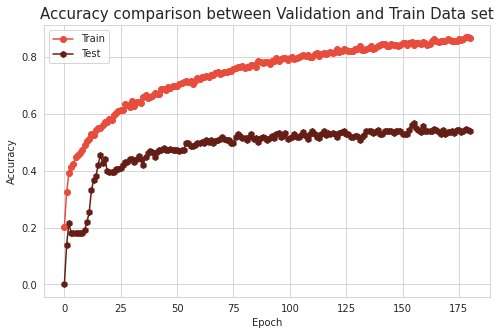

In [ ]:
acc_plot(history)

### **12.3 Confusion Matrix**

In [ ]:
y_probs = model.predict(X_test, verbose=0)
yhat_probs = np.argmax(y_probs, axis=1) #Getting predicted labels
y_trues = np.argmax(y_test_encoded, axis=1)

In [ ]:
cm = confusion_matrix(y_trues, yhat_probs)
cm

array([[279,   5,  46,   3,  49,  36,   0,  59,  11,  12],
       [  4, 153,   4,   8,  11,   2,   6,   6,   7,  20],
       [ 21,   3, 352,  40,  11,  14,   2,   4,  24,  29],
       [ 33,   2,  43, 361,   9,   9,  14,  10,  12,   7],
       [ 30,  17,   5,  43, 234,  15,   4, 133,  11,   8],
       [113,   1,   4,   7,   2, 229,   6, 106,   6,   9],
       [  0,   1,   0,  14,   0,   0, 169,   0,   0,   0],
       [ 24,   0,   1,   2, 128,   8,   3, 283,   3,   0],
       [  8,   8,   2,  37,  14,   2,   0,   7, 285,  30],
       [ 12,   5,  91,  11,  19,   7,   0,   7,  23, 325]])

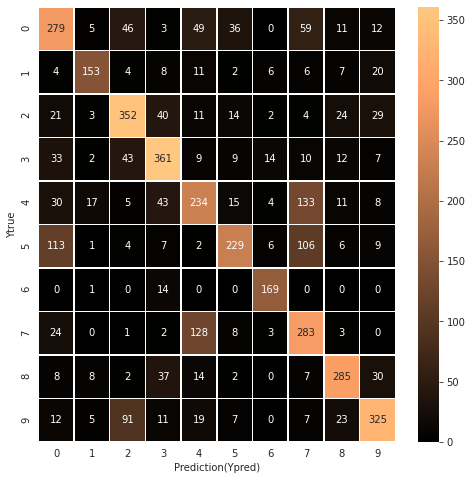

In [ ]:
def display_cm():
  CM = confusion_matrix(y_trues, yhat_probs)
  f, ax = plt.subplots(figsize=(8,8))
  sb.heatmap(CM,annot = True, linewidths=0.5,linecolor="white",fmt=".0f",ax=ax, cmap=plt.cm.copper)
  plt.xlabel("Prediction(Ypred)")
  plt.ylabel("Ytrue")
  plt.show()
display_cm()

### **12.5 Classification Report**

In [ ]:
re = classification_report(y_trues, yhat_probs, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)
print(re)

                  precision    recall  f1-score   support

 Air Conditioner       0.53      0.56      0.54       500
        Car Horn       0.78      0.69      0.74       221
Children Playing       0.64      0.70      0.67       500
        Dog bark       0.69      0.72      0.70       500
        Drilling       0.49      0.47      0.48       500
   Engine Idling       0.71      0.47      0.57       483
        Gun Shot       0.83      0.92      0.87       184
      Jackhammer       0.46      0.63      0.53       452
           Siren       0.75      0.73      0.74       393
    Street Music       0.74      0.65      0.69       500

        accuracy                           0.63      4233
       macro avg       0.66      0.65      0.65      4233
    weighted avg       0.64      0.63      0.63      4233



### **12.6 Accuracy per Class**

In [ ]:
accuracies = acc_per_class(cm)
pd.DataFrame({
    'CLASS': labels,
    'ACCURACY': accuracies}).sort_values(by="ACCURACY", ascending=False)

,CLASS,ACCURACY
6,Gun Shot,91.847826
8,Siren,72.519084
3,Dog bark,72.200000
2,Children Playing,70.400000
1,Car Horn,69.230769
9,Street Music,65.000000
7,Jackhammer,62.610619
0,Air Conditioner,55.800000
5,Engine Idling,47.412008
4,Drilling,46.800000
